# Table of Contents
* [Monitoring of the sunspots jumps  ($N_s$)](#Monitoring-of-the-sunspots-jumps--%28$N_s$%29)
	* [Load the data](#Load-the-data)
		* [Long-term error](#Long-term-error)
	* [Phase I SPC: Estimation of the regular patterns](#Phase-I-SPC:-Estimation-of-the-regular-patterns)
		* [Selection of the pool of stable stations](#Selection-of-the-pool-of-stable-stations)
		* [Standardization](#Standardization)
		* [Plot of the residuals (i.e. the standardized observations) distributions](#Plot-of-the-residuals-%28i.e.-the-standardized-observations%29-distributions)
	* [Phase II SPC: Monitoring](#Phase-II-SPC:-Monitoring)
	* [Design of the CUSUM chart](#Design-of-the-CUSUM-chart)
		* [Choice of the block length](#Choice-of-the-block-length)
		* [Choice of  the shift size ($\delta$)](#Choice-of--the-shift-size-%28$\delta$%29)
		* [Selection of the control limit of the chart.](#Selection-of-the-control-limit-of-the-chart.)
	* [Train and validate the classifier and regressor](#Train-and-validate-the-classifier-and-regressor)
		* [Set the parameters](#Set-the-parameters)
		* [Compute the control limit in absence of missing values](#Compute-the-control-limit-in-absence-of-missing-values)
		* [Select the length of the input vector](#Select-the-length-of-the-input-vector)
		* [Train and validate the models](#Train-and-validate-the-models)
	* [Run the control chart and show the results](#Run-the-control-chart-and-show-the-results)


#  Monitoring of the sunspots jumps  ($N_s$) 

In [1]:
import pickle
import numpy as np 
import pkg_resources as pkg
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6.0)
import warnings
warnings.simplefilter('ignore')

from SunSpot import errors as err
from SunSpot import preprocessing as pre
from SunSpot import cusum_design_bb as chart
from SunSpot import alerts as plot
from SunSpot import svr_svc_training as svm
from SunSpot import block_length as bbl

## Load the data

In [2]:
### load data (loaded automatically with package)
data_path = pkg.resource_filename(pkg.Requirement.parse("SunSpot"), 'data')

with open(data_path + '\data_1981', 'rb') as file: 
    my_depickler = pickle.Unpickler(file)
    Ns = my_depickler.load() #number of spots
    Ng = my_depickler.load() #number of sunspot groups
    Nc = my_depickler.load() #composite: Ns+10Ng
    station_names = my_depickler.load() #index of the stations
    time = my_depickler.load() #time

### Long-term error

The first step of the monitoring is to compute the long-term error, which accounts for systematic bias of the stations.  <br>
This error may be estimated by the following equation:
$$ \hat \mu_2(i,t) = \left( \frac{ Y_i(t)}{M_t} \right)^\star ~ \ \text{when} \ M_t>0 $$
where 
- the $\star$ denotes the smoothing process by a moving average (MA) ;
- $Y_i(t)$ are the raw observations (counts) in station $i$ at time $t$ ; 
- $M_t=\underset{1 \leq i\leq N}{\text{med}} Z_i(t)$ is the median of the network ; 
- $Zi(t)$ are the rescaled data, defined as $ Z_i(t) = \frac{Y_i(t)}{\kappa_i(t)} $ and  
-  $\kappa_i(t)$ are the scaling-factors, calculated using the ordinary least-squares regression (OLS) of the observations on the median of the network. <br>

As explained in <a id="ref-1" href="#cite-Mathieu2019">(Mathieu 2019, section 4)</a>, the duration of the period where the scaling-factors are assumed to be constant may be selected by a statistical-driven study based on the Kruskal-Wallis test <a id="ref-2" href="#cite-Kruskal_Wallis">(Kruskal & Wallis 1952)</a>. This test shows that the minimal time-scale is equal to 8 months for Ns. <br>
The scaling-factors may thus be computed on periods of 8 months. Afterwards, the data may be rescaled by these factors and the median of the network, $M_t$, may be evaluated on the rescaled observations. <br>
After dividing the observations by $M_t$, we also smooth the ratio by a moving average (MA) of length larger than or equal to 27 days to remove the influence of the short-term ($\epsilon_1$). Here, we choose a length equal to 27 days to better highlight the long-term jumps.
Whereas a larger scale such as 365 or 730 days may be selected to highlight the drifts. <br>

The function which computes the long-term error contains the main following parameters (for more info look directly at the documentation on top of the function): 
- data : the raw observations (here Ns)
- period_rescaling : period where the scaling-factors are assumed to be constant, expressed in months (8 months are selected here).
- wdw : the length of the MA, expressed in days (27 days are selected here)


In [3]:
mu2 = err.long_term_error(Ns, period_rescaling=8, wdw=27)

#discard stations with no values
ind_nan = []
for i in range(mu2.shape[1]):
   if not np.all(np.isnan(mu2[:,i])): 
       ind_nan.append(i)
mu2 = mu2[:,ind_nan]
station_names = [station_names[i] for i in range(len(station_names)) if i in ind_nan]
(n_obs, n_series) = mu2.shape

The long-term errors have different levels in each station, due to differences of instruments or counting methodology. <br>
Therefore, we first remove these levels (which correspond to the 'k' factors) from the long-term errors, since we are not interested in monitoring these differences. To identify the levels, we assume that they live on a longer scale than the errors (smoothed on 27 days for the jumps and 365 or 730 for the drifts). <br>
Hence, we remove the levels by subtracting a moving average of length equal to eleven years (or one solar cycle) from the errors, a physical scale of the data that is larger than 365 days.

In [4]:
### Apply preprocessing
dataNs = pre.PreProcessing(mu2) #the preprocessing in encapsulated in a class!
### Remove intrisic levels from the series
dataNs.level_removal(wdw=4000) #4000 days ~ eleven years 

<!-- https://stackoverflow.com/questions/30061902/how-to-handle-citations-in-ipython-notebook -->
We can now apply the monitoring procedure on the long-term errors without levels. <br>
The statistical process control (SPC) that we used is based on <a id="ref-3" href="#cite-Qiu2014">(Qiu 2014)</a>. It is composed of two phases. 
In the first phase, the regular patterns, i.e. the mean and the variance of the data, are estimated on a subset of stable or in-control stations, often called 'pool' in the following. Then, the observations of all stations are standardized by these parameters. In the second phase, a CUSUM chart <a id="ref-4" href="#cite-Page1961">(Page 1961)</a> is applied on the standardized observations for the quality control. <br>
A support vector machine classifier and regressor <a id="ref-5" href="#cite-Cheng2011">(Cheng 2011)</a> are also trained and validated on simulated data to allow the prediction of the size and the form of the shifts after each alert.

## Phase I SPC: Estimation of the regular patterns

### Selection of the pool of stable stations 

First, the pool of in-control (IC) or stable stations is selected from the network using k-means clustering <a id="ref-6" href="#cite-Lloyd1957">(Lloyd 1957)</a>, a general-purpose algorithm that groups the series into two clusters (one corresponding to the IC stations and the other to the unstable or out-of-control (OC) stations). 

In [5]:
### Selection of the IC pool 
dataNs.selection_pools(method='kmeans')
pool = np.array(dataNs.pool) #pool (number)
pool_ind = [station_names[i] for i in range(n_series) if i in pool] #pool (index)
print("n_pool: ", len(pool))
print(pool_ind)

n_pool:  150
['A2', 'AN', 'AT', 'BY', 'CA', 'CP', 'DS', 'EB', 'FU', 'GE', 'HE', 'HU', 'KA', 'KH', 'KO', 'KZ', 'LE', 'LK', 'MC', 'MD', 'RO', 'SA', 'SG', 'SK', 'SR', 'TI', 'UC', 'YV', 'DB', 'NY', 'QU', 'TR', 'KY', 'PK', 'AL', 'DU', 'EF', 'GU', 'GZ', 'NZ', 'A4', 'BI', 'DM', 'RB', 'RK', 'SC', 'SL', 'SY', 'TY', 'VE', 'JJ', 'JR', 'OM', 'AF', 'AU', 'CH', 'CL', 'EV', 'RS', 'ST', 'AP', 'AS', 'CC', 'HB', 'LS', 'OV', 'VD', 'FC', 'MS', 'SP', 'ZA', 'DC', 'DR', 'HR', 'JO', 'TD', 'TS', 'VB', 'CT', 'JB', 'PL', 'SO', 'KL', 'AE', 'HP', 'IS', 'ML', 'AO', 'BJ', 'HM', 'FF', 'FL', 'FS', 'FV', 'JK', 'PR', 'OE', 'VK', 'OH', 'GS', 'JP', 'GY', 'JD', 'AD', 'EP', 'HT', 'MN', 'RE', 'NP', 'JS', 'LM', 'TH', 'CK', 'CS', 'GB', 'JC', 'JY', 'VN', 'WM', 'FD', 'SH', 'VA', 'BT', 'BW', 'HL', 'ME', 'SI', 'YT', 'BV', 'DV', 'RI', 'RP', 'WW', 'IU', 'JM', 'JV', 'KI', 'TM', 'AI', 'VJ', 'DP', 'LT', 'MF', 'VU', 'DJ', 'KW', 'LI', 'MJ', 'TK', 'DT']


Since we expect that the stable stations may also suffer from several important deviations (however less numerous and/or smaller than those of the unstable or OC series), we also remove the daily outliers of the pool. 
This procedure removes each day the IC observations that do not fall into one standard deviation about the mean of the network. 

In [6]:
#remove outliers that do not fall into one standard deviation (k=1) about the mean of the network
dataNs.outliers_removal(k=1) 

### Standardization

Then, the data (IC and OC) are standardized by time-varying mean and variance. These quantities are computed across the pool of IC stations and along the time using K nearest neighbors (K-NN) estimators. Hence, the mean and the variance are always computed on the same number of values (=K) even if the data contain missing values. <br>
To automatically choose an appropriate value for 'K', we compute the standard deviation (std) of the standardized data for different values of K. The std decreases as 'K' augments (contrarily to the mean which usually increases when 'K' augments). Finally, we select the value of 'K' as the 'knee' of the std curve.

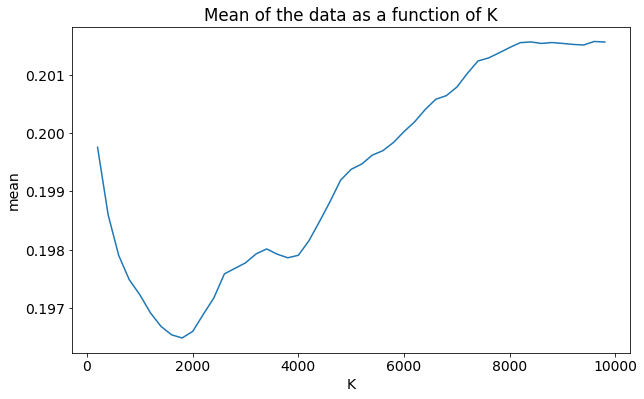

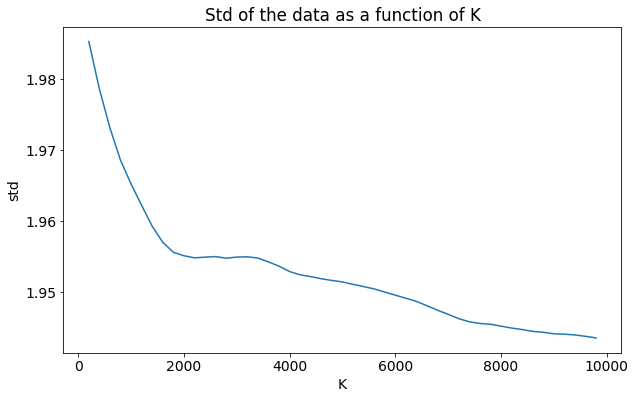

K where mean is closer to 0:  1800
K where std is closer to 1:  9800
K =  1800
n_days =  12.0
n_obs_IC: 55.63232670778433


In [7]:
### Choice of K 
dataIC = dataNs.dataIC  #IC data without deviations
data = dataNs.data #data (IC and OC) with deviations
K = pre.choice_K(data, dataIC, plot=True)
print('K = ', K)
print('n_days = ', K/len(pool))
dataNs.standardisation(K) #standardization of the data

dataIC = dataNs.dataIC  #IC data without deviations
data = dataNs.data #data (IC and OC) with deviations
n_obs_IC = len(dataIC[~np.isnan(dataIC)])*100 / len(data[~np.isnan(data)])
print('n_obs_IC:', n_obs_IC)

In [8]:
(n_obs, n_series) = data.shape #dimensions 

### Plot of the residuals (i.e. the standardized observations) distributions

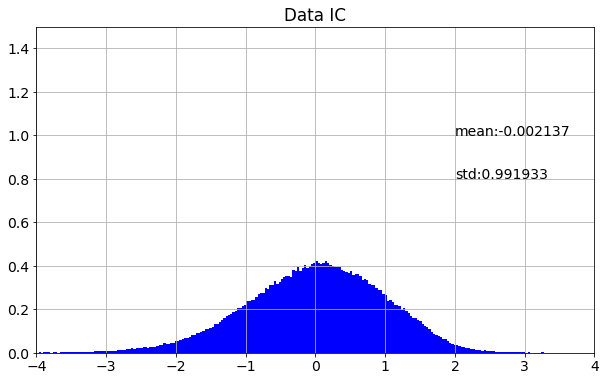

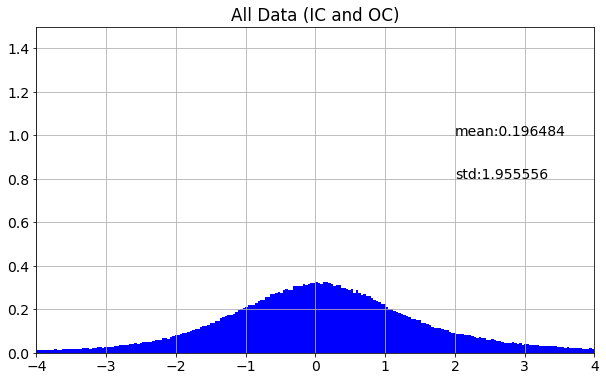

In [9]:
#plot the (IC) data
plt.hist(dataIC[~np.isnan(dataIC)], range=[-4,4], bins='auto', density=True, facecolor='b')  
plt.title("Data IC")
plt.text(2, 1, 'mean:' '%4f' %np.nanmean(dataIC))
plt.text(2, 0.8, 'std:' '%4f' %np.nanstd(dataIC))
plt.axis([-4, 4, 0, 1.5])
plt.grid(True)
plt.show()

#plot all data
plt.hist(data[~np.isnan(data)], range=[-4,4], bins='auto', density=True, facecolor='b')  
plt.title("All Data (IC and OC)")
plt.text(2, 1, 'mean:' '%4f' %np.nanmean(data))
plt.text(2, 0.8, 'std:' '%4f' %np.nanstd(data))
plt.axis([-4, 4, 0, 1.5])
plt.grid(True)
plt.show()

## Phase II SPC: Monitoring

## Design of the CUSUM chart

### Choice of the block length

The control chart is adjusted on the data using monte-carlo simulations. 
To avoid any parametric assumptions about the distribution or the autocorrelation of the data, we use the block bootstrap, a procedure that randomly samples blocks of observations with repetition from the data to generate new series similar to the observations. <br>
An important parameter of the method is thus the length of the blocks. Large blocks usually model the autocorrelation of the data properly but at the same time do not represent well the variance and the mean of the series. And conversely. Therefore, we compute an appropriate value for the block length by the following procedure. <br>
For each block length tested, we resample several series of observations using a block bootstrap procedure. Then, the mean squared error (mse) of the mean, the standard deviation and the autocorrelation at different lags are computed on
the resampled series (with respect to the original data). The appropriate value for the block length is finally selected as the first value such that the mse of the autocorrelation starts to stabilize (the "knee" of the curve). <br>
Intuitively, this length corresponds to the first value such that the main part of the autocorrelation is well represented. <br>

The function which computes the block length contains the main following parameters (for more info look directly at the documentation on top of the function): 
- data : the IC data (without major deviations)
- wdw_min : starting value for the block length (here set to 10)
- wdw_max : upper value for the block length (here set to 100)
- wdw_min : step value for the block length (here set to 10) <br>
The different values for the block length are thus contained in the range [wdw_min, wdw_max] with step value 'wdw_step'.

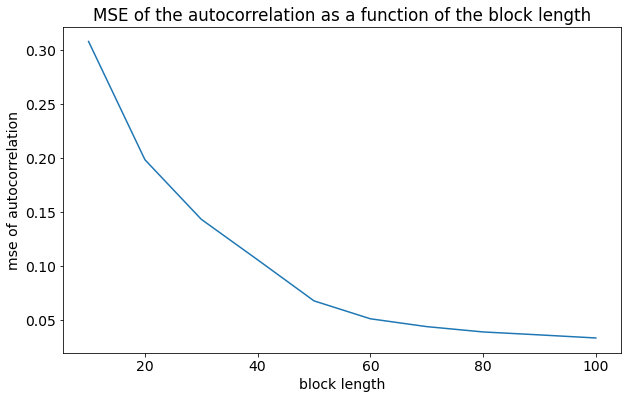

Block length which minimizes the mse of the mean: 10.0
Block length which minimizes the mse of the std: 10.0
Block length which minimizes the mse of the autocorrelation: 100.0


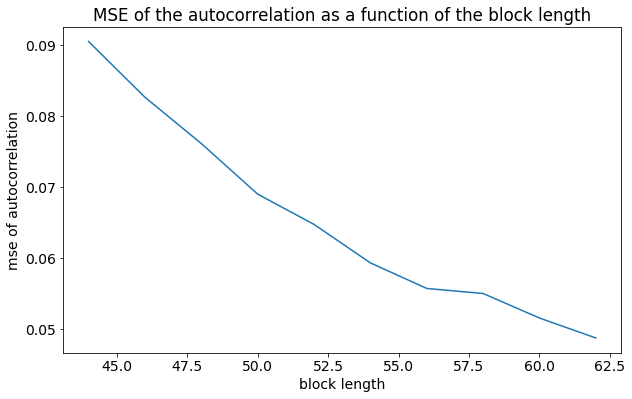

Block length which minimizes the mse of the mean: 46.0
Block length which minimizes the mse of the std: 46.0
Block length which minimizes the mse of the autocorrelation: 62.0
selected block length:  54.0


In [10]:
bb_length = bbl.block_length_choice(data=dataIC, wdw_min=10, wdw_max=110, wdw_step=10)
bb_length = bbl.block_length_choice(data=dataIC, wdw_min=44, wdw_max=64, wdw_step=2)
print('selected block length: ', bb_length)

### Choice of  the shift size ($\delta$)

The target shift size that it is interesting to detect ($\delta$) depends on the deviations that the series experience. <br>
This parameter may be estimated recursively as follows. 
For an initial value of the shift size, we may compute the control limits of the chart. Then, the chart may be applied on out-of-control series and the size of the deviations may be estimated after each alert using a classical formula <a id="ref-7" href="#cite-Montgomery2005">(Montgomery 2005)</a>. This formula is only valid for iid normal observations however it may still be used as a first approximation (the real shift sizes will be predicted later using a support vector regressor). 
Then, the value of the shift size may be updated such as a specified quantile of the shift size distribution. 
The procedure may then be iterated until the shift size converges. <br>
Since the shift size are expected to variate over a wide range, we select $\delta$ as the 0.5 quantile of the shift sizes distribution (the median).
We obtain a target shift size close to 1.5 that we round to 1.5.
<br>

The above-described function contains the main following parameters (for more info look directly at the documentation on top of the function): 
- data : the data (IC and OC)
- pool : the index of the IC series among all series 
- dataIC : the IC data (without major deviations)
- delta : the initial value for the target shift size (here set to 1)
- ARL0_threshold : the pre-specified value of the average run length (ARL0). <br>
This value controls the rate of false positives (the rate of false positivse is inversely proportional to the ARL0). It is set to 200.
- block_length : the length of the blocks (block boostrap procedure)
- qt : the quantile of the shift size distribution (here set to 0.5)
- missing_values : policy to treat the missing values. <br>
The missing values policy is set to 'reset'. In this mode, the chart is calculated on data that contain missing observations and is reset at each missing value (chart statistics = 0). 

In [11]:
bb_length = 54 
delta_min = 1 #intial value for the target shift size
ARL0 = 200 #pre-specified ARL0 (controls the false positives rate)

### estimate an appropriate shift size (specified quantile = 0.5)
control_limit, delta_min = chart.reccurentDesign_CUSUM(data, pool, dataIC=dataIC,
                delta=delta_min, ARL0_threshold=ARL0, block_length=bb_length, 
                qt=0.5, missing_values ='reset')

369.97254099734204
15.0
137.83352009114247
22.5
233.8713862204159
18.75
180.01323525130883
20.625
211.68851326217555
19.6875
197.84610462794845
20.15625
202.0974252795886
19.921875
198.53784010945762
20.0390625
control limit:  20.0390625
shift size:  1.610580807847042
746.5849071903957
15.0
285.7508493689761
7.5
132.57895713662714
11.25
197.1315271714139
13.125
239.349869389125
12.1875
215.81476934259823
11.71875
206.71466372629015
11.484375
202.90066690430956
11.3671875
203.59097896724185
11.30859375
202.94756729517442
11.279296875
198.9120233241384
11.2939453125
control limit:  11.2939453125
shift size:  1.5695855507896401


### Selection of the control limits of the chart.

The CUSUM gives an alert when the chart statistics (based on a cumulative sum of past observations) exceed certain values, called the 'control limits'. 
Here, we select the control limits on the data for the previously selected value of the target shift size $\delta$. 
The searching algorithm adjusts the values of the limits until a pre-specified value for the rate of false positive (ARL0) is reached to a desired accuracy. <br>

The function used contains the main following parameters (for more info look directly at the documentation on top of the function): 
- dataIC : the IC data (without major deviations)
- delta : the target shift size (here selected at 1.5)
- ARL0_threshold : the pre-specified value of the average run length (ARL0). <br>
This value controls the rate of false positives (the rate of false positivse is inversely proportional to the ARL0). It is set to 200.
- block_length : the length of the blocks (block boostrap procedure)
- missing_values : policy to treat the missing values. <br>
The missing values policy is set to 'reset'. With this policy, the chart is calculated on data that contain missing observations and is reset at each missing value (chart statistics = 0). 

The function returns the positive value for the control limit. The negative limit has the same value as the positive one with opposite sign since the distribution of the residuals is (almost) symmetric. 

In [12]:
delta_min = 1.5
control_limit = chart.search_CUSUM_MV(dataIC, delta=delta_min, ARL0_threshold=200,
                block_length=bb_length, missing_values='reset')

669.5524986618951
15.0
244.42545275502167
7.5
118.69036512038383
11.25
173.43996796874862
13.125
205.64560380046345
12.1875
192.91334320343063
12.65625
198.15559689507083
12.890625


## Train and validate the classifier and regressor

### Set the parameters

The deviations that are simulated to train the classifier and regressor are very general. <br>
Three forms of shifts are generated: jumps, drifts with varying power-law functions and oscillating shifts with different frequencies. 
Therefore, the only parameters that should be selected are the number of training and testing instances (n) and the scale of the half-normal distribution used to simulate the size of the shifts. This function samples random numbers in the range [delta, inf]. <br>
The number of instances is selected at 63000 (21000 for each form of shift).
The scale parameter depends on the expected deviations of the data and should be selected such as the highest deviations of the data are well reproduced. We choose here 3.5 since the data contain large deviations.

In [13]:
n = 21000*3 #number of testing and training instances
scale = 3.5 #scale parameter of the halfnormal distribution

### Compute the control limit in absence of missing values 

Previous values for the control limits are computed on data that may contain some missing values. 
However, the support vector machine procedures do not support missing observations (in practice, the missing observations are interpolated for the support vector machine predictions). Therefore, 
the training and the validation are entirely done on simulated data without missing values. 
This might require to readjust the control limits of the chart for data without missing values. This is done by setting the missing value policy  to 'omit' in the following function, which entirely supresses the blocks containing a missing observation. 

In [14]:
### compute the control limit of the chart without MVs
control_limit_mv = chart.search_CUSUM_MV(dataIC, delta=delta_min, ARL0_threshold=ARL0,
              block_length=bb_length, missing_values='omit')

455.77169498430015
15.0
211.42864316725772
7.5
113.41604776282202
11.25
160.2042324616921
13.125
183.27028999904132
14.0625
194.33787862892544
14.53125
201.6932258376019
14.296875


### Select the length of the input vector

The length of the input vector represents the number of past observations that are fed to the support vector classifier and regressor after each alert. The regressor and classifier then predict the form and the size of the shift that causes the alert based on this vector.  
Hence, the length should be sufficiently large to ensure that most of the shifts are contained within the input vector while maintaining the computing efficiency of the method. This is usually not a problem for the large shifts that are quickly detected by the chart. However the smallest shifts may be detected only after a certain amount of time and therefore require large vectors. <br>
Hence, the length is selected as an upper quantile of the run length distribution, computed on data shifted by the smallest shift size that we aim to detect. <br>
It is implemented as follows. <br>
For each monte-carlo run, a new series of observations is sampled from the IC data using a block bootstrap procedure. Then, a jump of size "delta_min' is simulated on top of the sample. The run length of the chart is then evaluated. The length of the input vector is finally selected as a specified upper quantile (quantile >=0.5) of the run length distribution. If the quantile is unspecified, an optimal quantile is selected by locating the 'knee' of the quantiles curve.  

The function that selected the length of the input vector contains the main following parameters (for more info look directly at the documentation on top of the function): 
- data : the IC data (without major deviations)
- delta : the target shift size (here set to delta_min)
- L_plus : the value of the upper control limit (here set to control_limit_mv)
- block_length : the length of the blocks (block boostrap procedure)

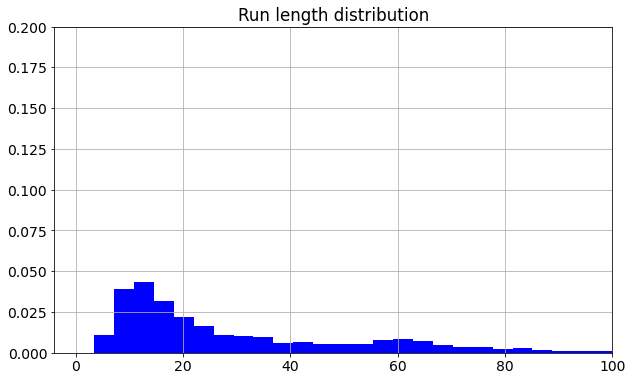

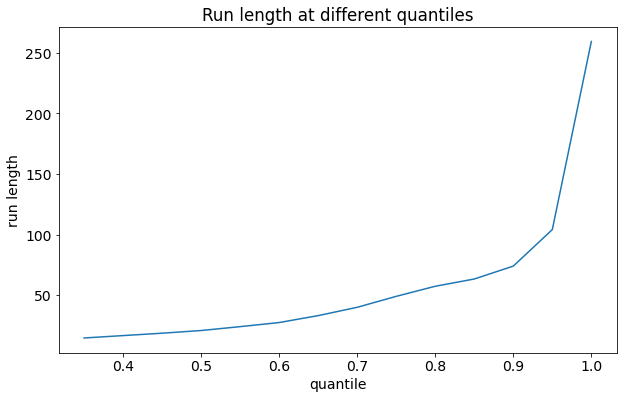

wdw_length:  74


In [15]:
wdw_length = svm.input_vector_length(dataIC, delta_min, L_plus=control_limit_mv, block_length=bb_length)
print('wdw_length: ', wdw_length)

In [16]:
wdw_length = 70 #for reproduciability purpose

### Train and validate the models

The function which trains and tests the support vector machine procedures contains the main following parameters (for more info look directly at the documentation on top of the function): 

- data : the IC data (without major deviations)
- L_plus : the value of the upper control limit (here set to control_limit_mv)
- delta : the target shift size (here set to delta_min)
- wdw_length : the length of the input vector (previously computed)
- scale : the scale parameter of the half-normal distribution (previously set to 3.5)
- delay : flag to start the monitoring after a random delay selected in the range [0, wdw_length/2]
- n : the total number of training and testing instances (previously set at 63000)
- C : the regularization parameter of the svm procedures (the strength of the regularization is inversely proportional to C). 
- block_length : the length of the blocks (block boostrap procedure)
- confusion : flag to print the confusion matrix

The regularization parameter (C) may be selected as a standard hyper-parameter of the method. 
For different values of C (in range ['start', 'stop'] with 'step' value in the following code), the training and the validation are applied on simulated data, with slightly less number of instances. The value of C that maximises the performances of the classifier and regressor is then selected. 
In particular, three performance criteria are computed here: the mean absolute percentage error (MAPE) together with the normalized root mean squared error (NRMSE) for the regressor and the accuracy for the classifier. <br>
When C is selected, the classifier and regressor may be trained once again on a larger number of instances.

In [17]:
#find an optimal value for C (regularization parameter)
C_choices = svm.choice_of_C(dataIC, control_limit_mv, delta_min, wdw_length, scale,
                    start = 5, stop = 15, step = 1,
              delay=True, n=12000*3, block_length=bb_length, confusion=False)

C value that minimizes the MAPE: 14
C value that minimizes the NRMSE: 14
C value that maximizes the accuracy: 11


C:  14
MAPE = 51.58952043769428
NRMSE = 0.7055226689384031
MAPE without signs = 30.71164213903243
NRMSE without signs = 0.3955481420089526
Accuracy = 96.07142857142857
Confusion matrix, without normalization
[[4159   11   30]
 [  45 4155    0]
 [ 403    6 3791]]
0.0004761904761904762
Normalized confusion matrix
[[0.9902381  0.00261905 0.00714286]
 [0.01071429 0.98928571 0.        ]
 [0.09595238 0.00142857 0.90261905]]
1.1337868480725623e-07


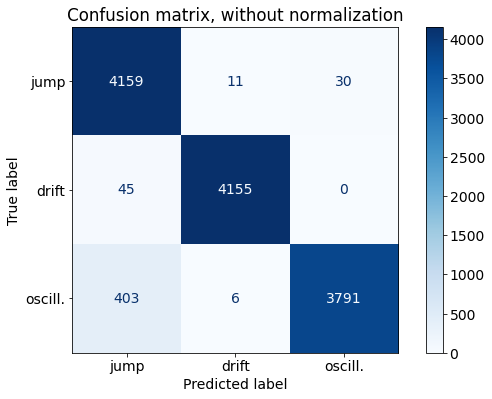

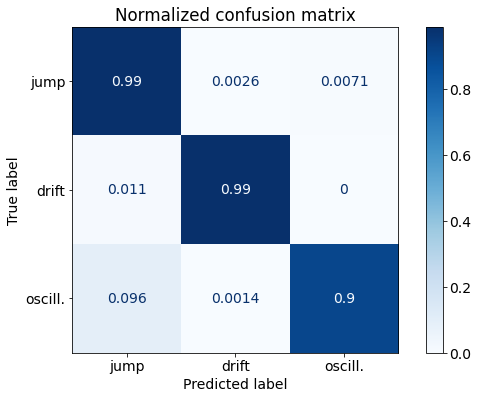

In [18]:
#train the classifier and regressor with selected C
C = C_choices[0]
print('C: ', C)
reg, clf = svm.training_svr_svm(dataIC, control_limit_mv, delta_min,
                wdw_length, scale, delay=True, n=n, C=C, block_length=bb_length)

### save models 
#filename = 'svr_Ns_27.sav'
#pickle.dump(reg, open(filename, 'wb'))
#filename = 'svc_Ns_27.sav'
#pickle.dump(clf, open(filename, 'wb'))

For reproduciability purpose, the models that are used in the article have been saved. <br>
Those are available on gitlab (https://gitlab-as.oma.be/SIDC/SILSO_USET/valusun) in the repository **svm_models**. The following commands may be used to load them (with appropriate paths).

In [19]:
#reg = pickle.load(open('../svm_models/svr_Ns_27.sav', 'rb'))
#clf = pickle.load(open('../svm_models/svc_Ns_27.sav', 'rb'))

## Run the control chart and show the results

The CUSUM chart is then applied on each series for the monitoring. 

The function that applied the CUSUM chart on a series contains the main following parameters (for more info look directly at the documentation on top of the function): 
- data : a single series of standardized observations
- L_plus : the value of the upper control limit (here set to control_limit)
- delta : the target shift size (here set to delta_min)
- wdw_length : the length of the input vector 
- clf : the trained classifier (model)
- reg : the trained regressor (model)

It gives back the chart statistics (C_plus and C_minus), the predicted shift forms after each alert (form_plus and form_minus) and the predicted shift sizes after each alert (size_plus and size_minus). When the series is not in alert, the sizes and forms of the shifts are set to NaNs. <br>
To avoid exploding CUSUM values when large deviations appear in the data, the CUSUM chart is ceiled slightly over the control limits. Hence, the duration of the out-of-control periods better corresponds to the actual duration of the shifts. <br>

Then, the main features of the monitoring are shown into four panels.  
The first panel represents the data with levels, the second shows the standardized residuals (without levels), 
the third panel displays the CUSUM statistics applied on the residuals and the last panel shows the predicted shift sizes and forms.

The function that shows the panels contains the main following parameters (for more info look directly at the documentation on top of the function): 

- data : a single series of standardized observations
- level : the same series with level (and without standardization)
- L_plus : the value of the upper control limit (here set to control_limit)
- time : an array with the time of the observations
- form_plus, form_minus : the predicted shift forms
- size_plus, size_minus : the predicted shift sizes
- C_plus, C_minus : the CUSUM statistics
- name : the code name of the station
- time_start : the starting time value of the figure

Percentage of alerts: 45.57


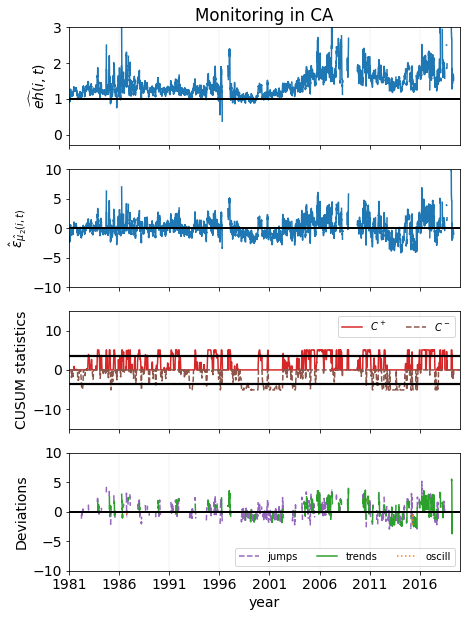

Percentage of alerts: 37.42


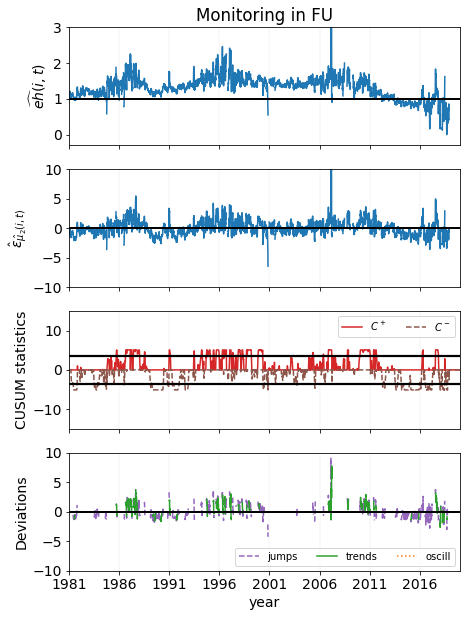

Percentage of alerts: 73.19


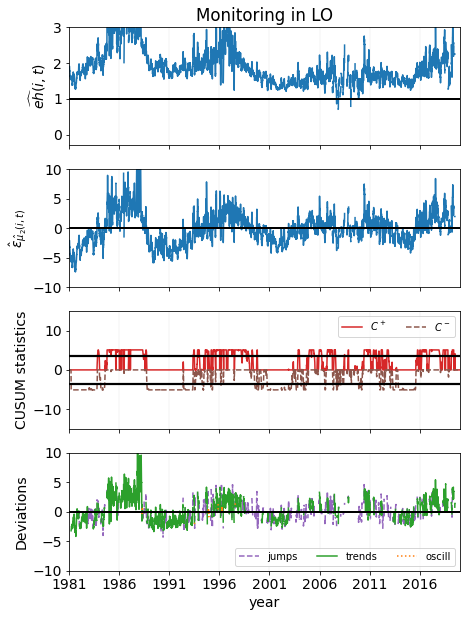

Percentage of alerts: 50.88


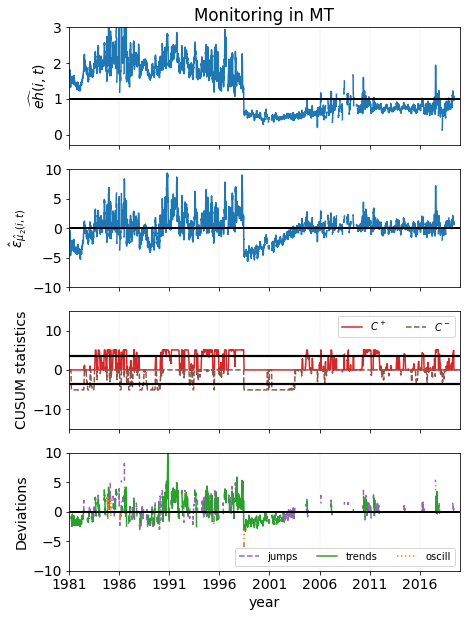

Percentage of alerts: 68.16


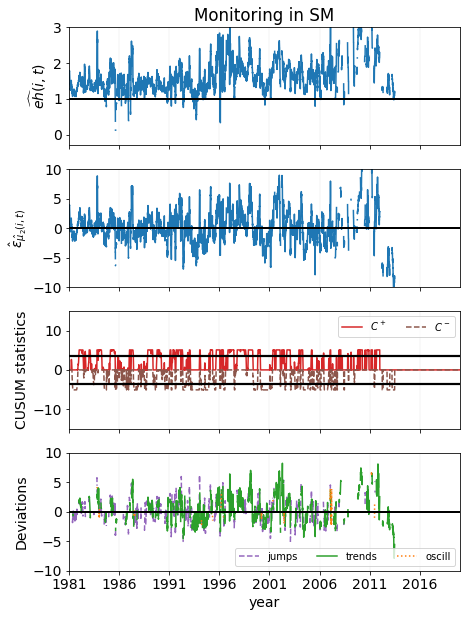

Percentage of alerts: 42.03


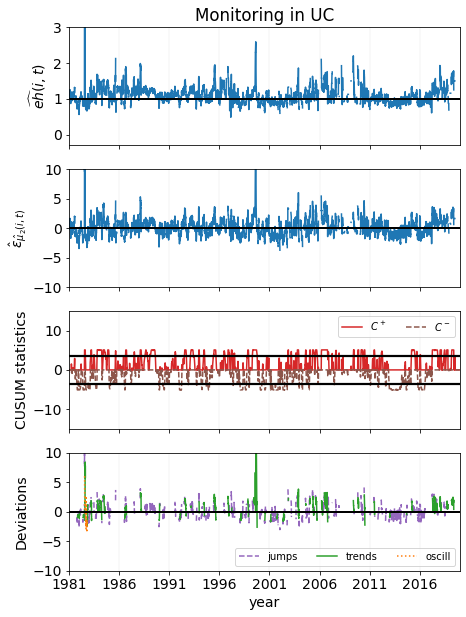

In [20]:
ind = [i for i in range(n_series) if station_names[i] in ['FU','UC','LO','SM','CA','MT']]

for i in ind: 
    data_indv = data[:,i]
    level_indv = mu2[:,i]
    
    [form_plus, form_minus, size_plus, size_minus,
    C_plus, C_minus] = plot.alerts_info(data_indv, control_limit, 
            delta_min, wdw_length, clf, reg)
    
    fig = plot.plot_monitoring(data_indv, level_indv, control_limit, time, 
                     form_plus, form_minus, size_plus, size_minus, 
                     C_plus, C_minus, station_names[i], time_start=1981)


<!--bibtex

@ARTICLE{Mathieu2019,
    AUTHOR={{Mathieu}, S. and {von Sachs}, R. and {Delouille}, V. and {Lefevre}, L. and {Ritter}, C.},
    TITLE="{Uncertainty quantification in sunspot counts}",
    JOURNAL={The Astrophysical Journal},
    YEAR={2019}, 
	volume = {886},
	number={1}, 
	pages= {}, 
	doi={https://doi.org/10.3847/1538-4357/ab4990}
}


@article{Kruskal_Wallis,
    author = {{Kruskal}, W. and {Wallis}, W.},
    title ="{Use of ranks in one-criterion variance analysis}",
    journal = {Journal of the American Statistical Association},
    volume = {47},
    number = {260},
    pages = {583-621},
    year = {1952},
    doi = {10.1191/1471082X04st068oa},
    URL = {https://www.jstor.org/stable/2280779}
}

@ARTICLE{Qiu2014,
    author={{Qiu}, P. and {Xiang}, D.},
    title = "{Univariate dynamic screening system: an approach for identifying individuals with irregular longitudinal behaviour}",
    journal = {Technometrics},
	volume = {56},
    number = {2},
    pages = {248-260},
    year = {2014},
	doi = {https://doi.org/10.1080/00401706.2013.822423},
    issn = {0040-1706}
}

@BOOK{Montgomery2005,
   author = {{Montgomery}, D},
   title = "{Introduction to Statistical Quality Control}",
   publisher={Wiley},
   year = {2004},
   edition = {5th}
}

@TechReport{Lloyd1957,
    author={{Lloyd}, S.P. },
    title = "{Least squares quantization in PCM}",
    institution = {Bell Lab},
    year = {1957},
    type = {Technical Report RR-5497},
    number = {5497}
}



@ARTICLE{Cheng2011,
    author={{Cheng}, C-S. and {Chen}, P-W. and {Huang}, K-K. },
    title = "{Estimating the shift size in the process mean with support vector regression and neural network}",
    journal = {Expert Systems with Applications},
    year = {2011},
	volume={38},
	number={8},
	pages={10624-10630},
	doi = {https://doi.org/10.1016/j.eswa.2011.02.121}
}


-->


<!--bibtex

@ARTICLE{Mathieu2019,
    AUTHOR={{Mathieu}, S. and {von Sachs}, R. and {Delouille}, V. and {Lefevre}, L. and {Ritter}, C.},
    TITLE="{Uncertainty quantification in sunspot counts}",
    JOURNAL={The Astrophysical Journal},
    YEAR={2019}, 
	volume = {886},
	number={1}, 
	pages= {}, 
	doi={https://doi.org/10.3847/1538-4357/ab4990}
}


@article{Kruskal_Wallis,
    author = {{Kruskal}, W. and {Wallis}, W.},
    title ="{Use of ranks in one-criterion variance analysis}",
    journal = {Journal of the American Statistical Association},
    volume = {47},
    number = {260},
    pages = {583-621},
    year = {1952},
    doi = {10.1191/1471082X04st068oa},
    URL = {https://www.jstor.org/stable/2280779}
}

@article{Page1961,
author = {{Page}, E. S.},
title ="{Cumulative sum charts}",
journal = {Technometrics},
volume = {3},
number = {1},
pages = {1-9},
year = {1961},
URL = {https://www.jstor.org/stable/1266472}
}
-->


# References

<a id="cite-Mathieu2019"/><sup><a href=#ref-1>[^]</a></sup>Mathieu, S. and von Sachs, R. and Delouille, V. and Lefevre, L. and Ritter, C.. 2019. _Uncertainty quantification in sunspot counts_.

<a id="cite-Kruskal_Wallis"/><sup><a href=#ref-2>[^]</a></sup>Kruskal, W. and Wallis, W.. 1952. _Use of ranks in one-criterion variance analysis_. [URL](https://www.jstor.org/stable/2280779)

<a id="cite-Qiu2014"/><sup><a href=#ref-3>[^]</a></sup>Qiu, P. and Xiang, D.. 2014. _Univariate dynamic screening system: an approach for identifying individuals with irregular longitudinal behaviour_.

<a id="cite-Cheng2011"/><sup><a href=#ref-5>[^]</a></sup>Cheng, C-S. and Chen, P-W. and Huang, K-K. . 2011. _Estimating the shift size in the process mean with support vector regression and neural network_.

<a id="cite-Lloyd1957"/><sup><a href=#ref-6>[^]</a></sup>Lloyd, S.P. . 1957. _Least squares quantization in PCM_.

<a id="cite-Montgomery2005"/><sup><a href=#ref-7>[^]</a></sup>Montgomery, D. 2004. _Introduction to Statistical Quality Control_.

